<a href="https://colab.research.google.com/github/snowman74/Neural-Networks/blob/main/%D0%9F%D1%80%D1%8F%D0%BC%D1%8B%D0%B5%20%D0%B8%20%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%20%D1%81%D0%B5%D1%82%D0%B8%20%D0%B4%D0%BB%D1%8F%20%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8%20%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание стилей музыки с помощью Dense сети

In [ ]:
import librosa # for parametrization audio
import matplotlib.pyplot as plt # for plot graphs
import librosa.display # for audio rendering
from google.colab import files # for loading files
import IPython.display as ipd # for playing audio
import numpy as np
from tensorflow.keras import utils
import os
%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Загружаем данные***

In [ ]:
import zipfile
z = zipfile.ZipFile('/content/drive/My Drive/Базы/21 занятие/genres.zip')
z.extractall()

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

!ls genres

!ls genres/classical

bextract_single.mf  classical  country	hi.mf	  ja.mf  metal	reggae	ro.mf
bl.mf		    cl.mf      di.mf	hiphop	  jazz	 po.mf	re.mf
blues		    co.mf      disco	input.mf  me.mf  pop	rock
classical.00000.wav  classical.00034.wav  classical.00068.wav
classical.00001.wav  classical.00035.wav  classical.00069.wav
classical.00002.wav  classical.00036.wav  classical.00070.wav
classical.00003.wav  classical.00037.wav  classical.00071.wav
classical.00004.wav  classical.00038.wav  classical.00072.wav
classical.00005.wav  classical.00039.wav  classical.00073.wav
classical.00006.wav  classical.00040.wav  classical.00074.wav
classical.00007.wav  classical.00041.wav  classical.00075.wav
classical.00008.wav  classical.00042.wav  classical.00076.wav
classical.00009.wav  classical.00043.wav  classical.00077.wav
classical.00010.wav  classical.00044.wav  classical.00078.wav
classical.00011.wav  classical.00045.wav  classical.00079.wav
classical.00012.wav  classical.00046.wav  classical.00080.wav
classical.00

***Функции для выделения признаков***

In [ ]:
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # получаем частоту цветности
  rmse = np.mean(librosa.feature.rmse(y=y)) # получаем среднеквадратичную амплитуду
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # получаем спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # получаем ширину полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) # получаем спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # получаем пересечения с нулем
  mfcc = librosa.feature.mfcc(y=y, sr=sr) # получаем Мел кепстральные коэффициенты

# формируем из всех признаков единый список
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  for e in mfcc:
    out.append(np.mean(e))

  for e in chroma_stft:
    out.append(np.mean(e))
  return out

In [ ]:
import time

X_train = []
Y_train = []

curr_time = time.time()

for i in range(len(genres)):
  g = genres[i]

  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)

    X_train.append(out)
    Y_train.append(utils.to_categorical(i, len(genres)))

  print('Жанр ', g, ' готов -> ', round(time.time() - curr_time), 'с', sep='')
  curr_time = time.time()

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 63с
Жанр classical готов -> 62с
Жанр country готов -> 63с
Жанр disco готов -> 64с
Жанр hiphop готов -> 64с
Жанр jazz готов -> 63с
Жанр metal готов -> 65с
Жанр pop готов -> 62с
Жанр reggae готов -> 61с
Жанр rock готов -> 62с


In [ ]:
np.save('/content/drive/My Drive/Базы/20 занятие/X_train_light.npy', X_train)
np.save('/content/drive/My Drive/Базы/20 занятие/Y_train_light.npy', Y_train)

In [ ]:
X_train = np.load('/content/drive/My Drive/Базы/20 занятие/X_train_light.npy')
Y_train = np.load('/content/drive/My Drive/Базы/20 занятие/Y_train_light.npy')

In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
print(X_train.shape)

(1000, 37)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
print(X_train.shape)

(900, 37)


***Пишем простую нейронную сеть***

In [ ]:
model = Sequential()

model.add(Dense(300, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(150, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(len(genres), activation='softmax'))

Epoch 1/1000
45/45 [==============================] - 0s 6ms/step - loss: 2.2888 - accuracy: 0.1089 - val_loss: 2.2391 - val_accuracy: 0.1300
Epoch 2/1000
45/45 [==============================] - 0s 3ms/step - loss: 2.1701 - accuracy: 0.2456 - val_loss: 2.1292 - val_accuracy: 0.2800
Epoch 3/1000
45/45 [==============================] - 0s 2ms/step - loss: 2.0358 - accuracy: 0.3667 - val_loss: 1.9894 - val_accuracy: 0.3700
Epoch 4/1000
45/45 [==============================] - 0s 2ms/step - loss: 1.8767 - accuracy: 0.3911 - val_loss: 1.8326 - val_accuracy: 0.4200
Epoch 5/1000
45/45 [==============================] - 0s 2ms/step - loss: 1.7160 - accuracy: 0.4222 - val_loss: 1.6897 - val_accuracy: 0.4400
Epoch 6/1000
45/45 [==============================] - 0s 2ms/step - loss: 1.5781 - accuracy: 0.4856 - val_loss: 1.5806 - val_accuracy: 0.4200
Epoch 7/1000
45/45 [==============================] - 0s 2ms/step - loss: 1.4667 - accuracy: 0.5122 - val_loss: 1.5060 - val_accuracy: 0.4400
Epoch 

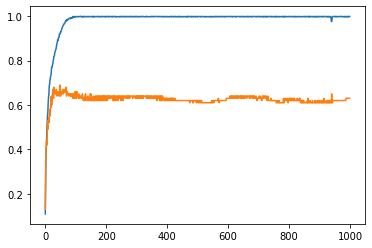

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=20,
                    validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Запустим сеть на полных данных всех коэффициентов, развёрнутых по частотам - одномерные и двумерные вектора.


In [ ]:
#Функция параметризации аудио расширенного списка признаков (PRO версия)
def get_features(y, sr):
  #Получаем различные параметры аудио
  rmse = librosa.feature.rmse(y=y) #Среднеквадратичная амплитуда 
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) #Спектральный центроид
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr) #Ширина полосы частот
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr) #Спектральный спад частоты
  zcr = librosa.feature.zero_crossing_rate(y) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности
  
  #Добавляем все параметры в один np массив
  out = rmse
  out = np.concatenate((out, spec_cent))    
  out = np.concatenate((out, spec_bw))      
  out = np.concatenate((out, rolloff))      
  out = np.concatenate((out, zcr))          
  out = np.concatenate((out, mfcc))
  out = np.concatenate((out, chroma_stft))
  
  return out

def getSetFromIndexes(audio, xLen, xStep):   # функция принимает аудио, размер окна, шаг окна
  xSample = []                                    # Объявляем переменную для векторов
  audioLen = audio.shape[1]                       # Считаем количество значений
  index = 0                                       # Задаем начальный индекс 
  while (index + xLen <= audioLen):               # Идём по всей длине вектора индексов
    xSample.append(audio[:,index:index+xLen])     # "Откусываем" массивы длины xLen
    index += xStep                                 # Смещаеммся вперёд на step
  
  return np.array(xSample)


In [ ]:
#Проверка работы функций
g = genres[3]
songname = f'/content/genres/{g}/disco.00001.wav'
y, sr = librosa.load(songname, mono=True, duration=30)
    #Превращаем сигнал в параметризованные данные
out = get_features(y, sr)

print(out.shape)
    #Разделяем аудиофайл на участки xLen с шагом xStep
out = getSetFromIndexes(out, 200, 100)
print(out.shape)

mfcc = librosa.feature.mfcc(y=y, sr=sr)
print(mfcc.shape)


(37, 1292)
(11, 37, 200)
(20, 1292)


In [ ]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Задаем параметры
xLen = 200
xStep = 100

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    y, sr = librosa.load(songname, mono=True, duration=30)
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Разделяем аудиофайл на участки xLen с шагом xStep
    out = getSetFromIndexes(out, xLen, xStep)
    
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку в numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 68c
Жанр classical готов -> 68c
Жанр country готов -> 67c
Жанр disco готов -> 67c
Жанр hiphop готов -> 68c
Жанр jazz готов -> 67c
Жанр metal готов -> 69c
Жанр pop готов -> 68c
Жанр reggae готов -> 68c
Жанр rock готов -> 70c


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(np.amax(X_train))
print(np.amin(X_train))

(1000, 11, 37, 200)
(1000, 10)
10798.9013671875
-678.8547296660762


In [ ]:
print(Y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [ ]:
#Выводим размеры Train и Test
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(900, 11, 37, 200)
(900, 10)
(100, 11, 37, 200)
(100, 10)


In [ ]:
def setNewSiseXY(x, y):
  newX = []
  newY = []
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      newX.append(x[i,j])
      newY.append(y[i])
  
  newX = np.array(newX)
  newY = np.array(newY)

  return newX, newY

x_test_backup = x_test
y_test_backup = y_test

x_train, y_train = setNewSiseXY(x_train, y_train)
x_test, y_test = setNewSiseXY(x_test, y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9900, 37, 200)
(9900, 10)
(1100, 37, 200)
(1100, 10)


In [ ]:
sh = (-1, xLen*37)

x_train01 = x_train.reshape(sh)
x_test01 = x_test.reshape(sh)

print(x_train01.shape)
print(y_train.shape)
print(x_test01.shape)
print(y_test.shape)
print(np.amin(x_train01), np.amax(x_train01))

(9900, 7400)
(9900, 10)
(1100, 7400)
(1100, 10)
-678.8547296660762 10798.9013671875


In [ ]:
# Нормируем данные StandardScaler'ом
scaler = StandardScaler()
scaler.fit(x_train01)
x_train01 = scaler.transform(x_train01)
x_test01 = scaler.transform(x_test01)

print(np.amin(x_train01), np.amax(x_train01))
print(x_train01.shape)

-6.845776916599175 10.091713290101914
(9900, 7400)


In [ ]:
# Размерность матрицы для слоя Conv1D
sh = (-1, xLen, 37)
#Меняем размерность
x_train = x_train01.reshape(sh)
x_test = x_test01.reshape(sh)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.amin(x_train), np.amax(x_train))

(9900, 200, 37)
(9900, 10)
(1100, 200, 37)
(1100, 10)
-6.845776916599175 10.091713290101914


In [ ]:
np.save('/content/drive/My Drive/Базы/20 занятие/x_train_pro.npy', x_train)
np.save('/content/drive/My Drive/Базы/20 занятие/y_train_pro.npy', y_train)
np.save('/content/drive/My Drive/Базы/20 занятие/x_test_pro.npy', x_test)
np.save('/content/drive/My Drive/Базы/20 занятие/y_test_pro.npy', y_test)

In [ ]:
# x_train = np.load('/content/drive/My Drive/Базы/20 занятие/x_train_pro.npy')
# y_train = np.load('/content/drive/My Drive/Базы/20 занятие/y_train_pro.npy')
# x_test = np.load('/content/drive/My Drive/Базы/20 занятие/x_test_pro.npy')
# y_test = np.load('/content/drive/My Drive/Базы/20 занятие/y_test_pro.npy')

In [ ]:
zipfile.ZipFile?

In [ ]:
valAccur = []

#Создаём сеть 
input = Input((xLen, 37))

x1 = Conv1D(40, 3, padding='same', activation='elu')(input)
x1 = Conv1D(80, 3, padding='same', activation='elu')(x1)

x1 = Dropout(0.5)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(120, 3, padding='same', activation='elu')(x1)
x1 = Conv1D(160, 3, padding='same', activation='elu')(x1)

fin = Flatten()(x1)
fin = Dropout(0.5)(fin)
fin = BatchNormalization()(fin)
fin = Dense(1000, activation='elu')(fin)
fin = Dense(len(genres), activation='softmax')(fin)

model = Model(input, fin)
model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 37)]         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 40)           4480      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 200, 80)           9680      
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 80)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 80)           320       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 200, 120)          28920     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 200, 160)         

In [ ]:
#Компилируем сеть
model.compile(optimizer=Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем всего на 10 эпохах, чтобы проверить что всё работает
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=20,
                    validation_data=(x_test, y_test)
                    # callbacks=[pltSave]
                    )

Epoch 1/10
495/495 [==============================] - 170s 344ms/step - loss: 2.4275 - accuracy: 0.4952 - val_loss: 2.6342 - val_accuracy: 0.5509
Epoch 2/10
495/495 [==============================] - 167s 338ms/step - loss: 1.7133 - accuracy: 0.6522 - val_loss: 2.4957 - val_accuracy: 0.5745
Epoch 3/10
495/495 [==============================] - 168s 340ms/step - loss: 1.1950 - accuracy: 0.7297 - val_loss: 2.3647 - val_accuracy: 0.5918
Epoch 4/10
495/495 [==============================] - 168s 339ms/step - loss: 0.8557 - accuracy: 0.7856 - val_loss: 2.2463 - val_accuracy: 0.5927
Epoch 5/10
495/495 [==============================] - 168s 339ms/step - loss: 0.6865 - accuracy: 0.8194 - val_loss: 2.3247 - val_accuracy: 0.5882
Epoch 6/10
495/495 [==============================] - 167s 338ms/step - loss: 0.5444 - accuracy: 0.8575 - val_loss: 2.2160 - val_accuracy: 0.6327
Epoch 7/10
495/495 [==============================] - 168s 338ms/step - loss: 0.4530 - accuracy: 0.8716 - val_loss: 2.2970 -

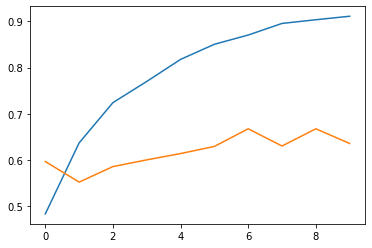

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
from scipy.stats import mode
# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, yTest):
  print("НЕЙРОНКА: ", model.name)
  print()
  
  totalSumRec = 0 # Сумма всех правильных 
  sumCount = 0
  currOut = []
  currVal = []
  # Проходим по всем аудио файлам
  for i in range(xTest.shape[0]):
    #Нормализуем данные
    sh = (-1, xLen*37)
    newX = xTest[i].reshape(sh)
    newX01 = scaler.transform(newX)
    sh = (-1, xLen, 37)
    newX = newX01.reshape(sh)

    #Получаем результаты распознавания класса по участкам
    currPred = model.predict(newX)
    #Определяем номер распознанного класса для каждохо участка
    currPred = np.argmax(currPred, axis=1)
    mode_=mode(currPred)[0] # вычисляем моду (коэф. встречающийся чаще всего)
    currPred = (np.ones((1,11))*mode_).reshape(11,)
    print(currPred)
    currY = np.argmax(yTest[i])
    #Определяем процент ошибки по аудиофайлу
    currOut.append(len(currPred[currPred==currY])/len(currPred))
    currVal.append(currY)

  #Проходим по всем классам
  for j in range(len(genres)):
    summVal = 0
    countVal = 0
    for i in range(len(currVal)):
      if currVal[i] == j: 
        summVal += currOut[i]
        countVal += 1
        totalSumRec += currOut[i]
        sumCount += 1
    
    evVal = summVal/countVal
    str1 = 'Класс: ' + genres[j] + " " * (11 - len(genres[j])) + str(int(100*evVal)) + "%"
    print(str1)
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')
  print()

recognizeMultiClass(model, x_test_backup, y_test_backup)

НЕЙРОНКА:  functional_3

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6.